In [125]:
import pandas as pd
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score

from kmodes.kprototypes import KPrototypes

# K-Means clustering

* standarization
* one-hot encoding

In [104]:
test_org = pd.read_csv(Path('..','adults_data','adults_imputed_test_data.csv'))
train_org = pd.read_csv(Path('..','adults_data','adults_imputed_train_data.csv'))

In [3]:
def one_hot_std(trainset,testset):
    
    numerical_colnames = trainset.select_dtypes(include=['number']).columns
    categorical_colnames = trainset.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[  
            ('num', StandardScaler(), numerical_colnames),
            ('cat', OneHotEncoder(sparse_output=False), categorical_colnames)
        ]  
    )

    train_processed = preprocessor.fit_transform(trainset)
    test_processed = preprocessor.fit_transform(testset)
    
    onehot_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_colnames)
    all_cols = list(numerical_colnames) + list(onehot_cols)

    train_processed = pd.DataFrame(train_processed, columns=all_cols)
    test_processed = pd.DataFrame(test_processed, columns=all_cols)
    
    return train_processed, test_processed

In [28]:
train_ohs, test_ohs = one_hot_std(train_org, test_org)

train_ohs.to_csv(Path('..','adults_data','adults_ohs_train'), index=False)
test_ohs.to_csv(Path('..','adults_data','adults_ohs_test'), index=False)

## Finding optimal $K$


---

### 1. Elbow Method

**Criterion:**

- We look for the point on the plot where WCSS (Within-Cluster Sum of Squares, i.e., the sum of squared distances of points from the nearest centroid) stops decreasing sharply and begins to decrease more slowly.
- The WCSS vs. number of clusters plot forms a "elbow" shape, where the "bend" indicates the optimal number of clusters.

**Interpretation:**

- The number of clusters at the elbow point is the optimal number of clusters.

### 2. Silhouette Coefficient

**Criterion:**

- Silhouette coefficient values range from -1 to 1.
- A high value (close to 1) indicates that points are well matched to their own cluster and poorly matched to neighboring clusters.

**Interpretation:**

- The higher the average silhouette coefficient, the better the clustering.
- Choose the number of clusters that maximizes the average silhouette coefficient.

### 3. Davies-Bouldin Score

**Criterion:**

- Davies-Bouldin Score values range from 0 to infinity.
- Lower values indicate better clustering because they represent smaller distances within clusters and greater distances between clusters.

**Interpretation:**

- The optimal number of clusters is the one that minimizes the Davies-Bouldin Score.

### 4. Calinski-Harabasz Index

**Criterion:**

- Calinski-Harabasz Index values range from 0 to infinity.
- Higher values indicate better clustering because they represent better separation between clusters and greater density within clusters.

**Interpretation:**

- The optimal number of clusters is the one that maximizes the Calinski-Harabasz Index.

---

In [168]:
def get_optimal_K(df, k_max):

    wcss = []
    silhouette_scores = []
    db_scores = []
    ch_scores = []
    #ar_scores = []
    
    for k in range(2, k_max+1):
        print("k=",str(k))
        kmeans = KMeans(n_clusters=k, max_iter=5000, random_state=42)
        labels = kmeans.fit_predict(df)        
        
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(df, labels))
        db_scores.append(davies_bouldin_score(df, labels))
        ch_scores.append(calinski_harabasz_score(df, labels))
        #ar_scores.append(adjusted_rand_score(df, labels))
        

    # Prepare data for visualization:
    measures = pd.DataFrame({'elbow':wcss,
                         'silh':silhouette_scores,
                         'dbi':db_scores,
                         'ch':ch_scores})
                         #'ar':ar_scores})
    measures.index += 1
    
    fig, axes = plt.subplots(2,2, figsize=(16,12))
    axes[0,0].plot(measures.index, measures['elbow'])
    axes[0,0].set_title("Elbow Method")
    axes[0,1].plot(measures.index, measures['silh'])
    axes[0,1].set_title("Silhouette Index")
    axes[1,0].plot(measures.index, measures['dbi'])
    axes[1,0].set_title("Davies Bouldin Index")
    axes[1,1].plot(measures.index, measures['ch'])
    axes[1,1].set_title("Calinski and Harabasz Score")
    """axes[4].plot(measures.index, measures['dbi'])
    axes[4].set_title("Rand Score")"""
    
    measures.to_csv(Path('..','adults_data','K-means_measures.csv'))
    return wcss

k= 2
k= 3
k= 4
k= 5
k= 6
k= 7
k= 8
k= 9
k= 10
k= 11
k= 12
k= 13
k= 14
k= 15


[257896.4298780848,
 236505.63408355755,
 223687.09203532978,
 216245.9099070252,
 207464.87639004152,
 177249.3131554698,
 168837.31075571149,
 162867.71987568933,
 159328.24531694132,
 157037.13336011622,
 154209.6912903759,
 150236.23956003063,
 147804.9072173225,
 145880.1698453147]

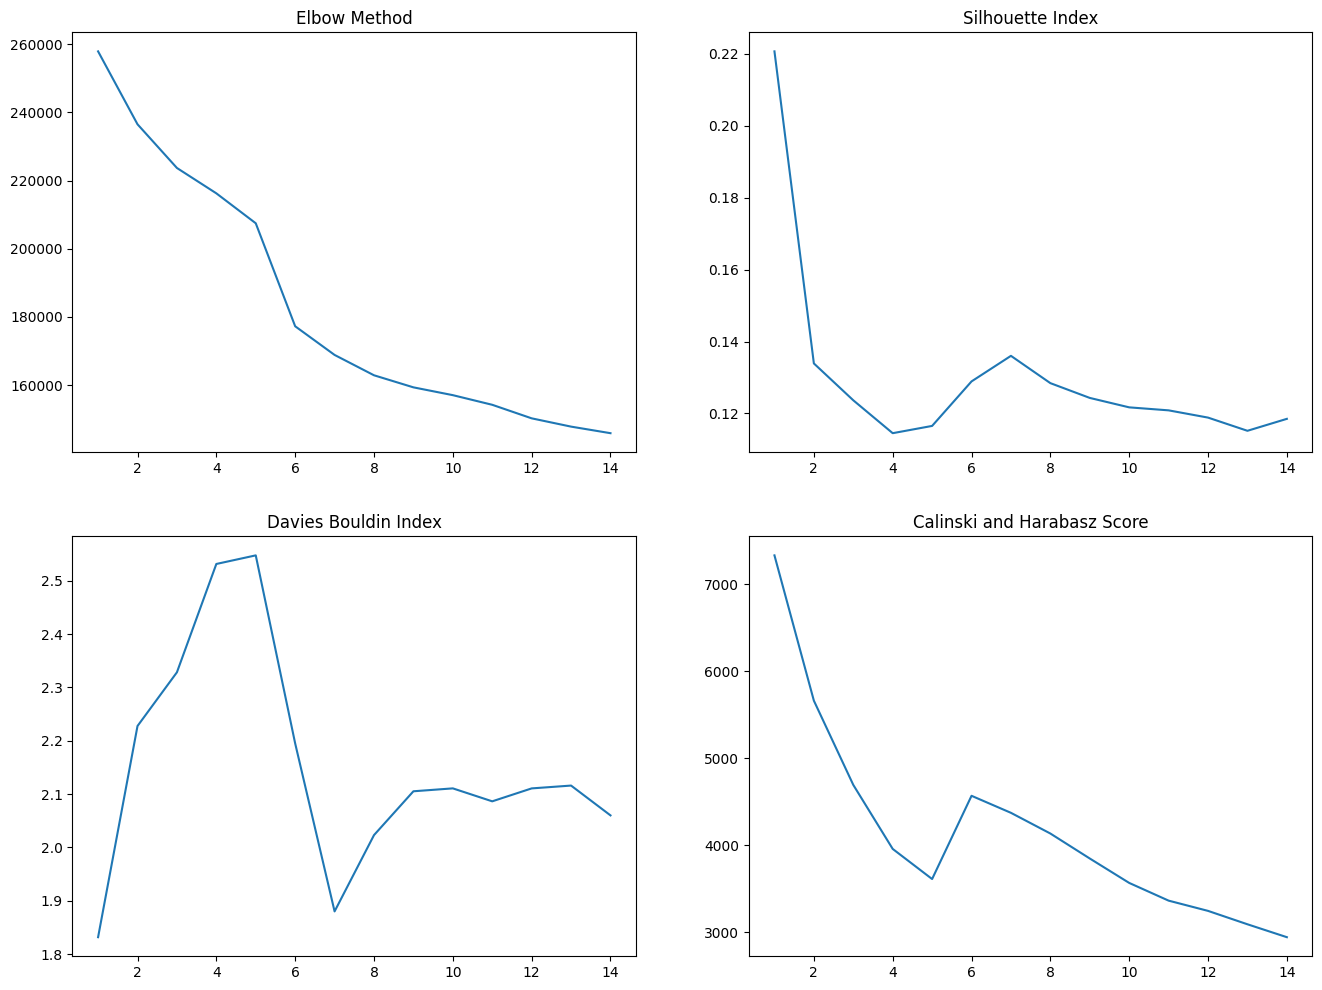

In [170]:
get_optimal_K(train_ohs, 15)

 **7** seems to be okay 

## plots

In [101]:
measures_df = train_org = pd.read_csv(Path('..','adults_data','K-means_measures.csv'), index_col=0)

In [102]:
measures_df

,elbow,silh,dbi,ch
1,257896.429878,0.220607,1.831731,7334.104496
2,236505.634084,0.133910,2.227678,5663.663760
3,223687.092035,0.123667,2.328383,4695.331357
4,216245.909907,0.114530,2.531487,3959.302476
5,207464.876390,0.116548,2.547616,3613.067617
6,177249.313155,0.128913,2.195033,4570.028196
7,168837.310756,0.136017,1.880075,4374.246695
8,162867.719876,0.128434,2.023115,4136.309874
9,159328.245317,0.124328,2.105297,3849.159774
10,157037.133360,0.121706,2.110746,3568.398139


(1.5, 16.0)

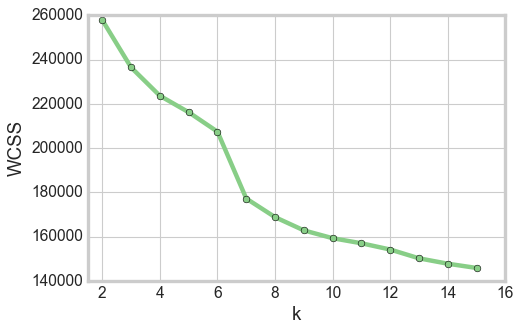

In [76]:
sns.set_style('whitegrid')
sns.set_palette('pastel')
palette = sns.color_palette("Greens", n_colors=8)
plt.rcParams['figure.figsize'] = (6,4)

plt.plot(np.arange(2,2+measures_df.shape[0]), measures_df['elbow'],
         marker='o', color=palette[3])
plt.xlabel('k')
plt.ylabel('WCSS')
plt.xlim(1.5,)

(1.5, 16.0)

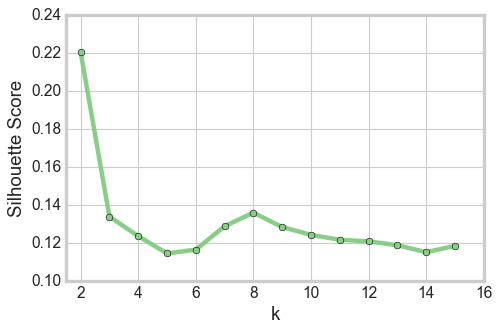

In [77]:
plt.plot(np.arange(2,2+measures_df.shape[0]), measures_df['silh'],
         marker='o', color=palette[3])
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.xlim(1.5,)

(1.5, 16.0)

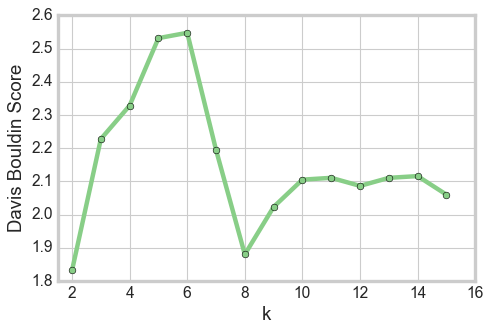

In [81]:
plt.plot(np.arange(2,2+measures_df.shape[0]), measures_df['dbi'],
         marker='o', color=palette[3])
plt.xlabel('k')
plt.ylabel('Davis Bouldin Score')
plt.xlim(1.5,)

(1.5, 16.0)

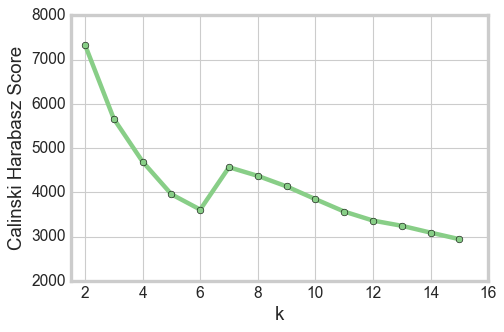

In [84]:
plt.plot(np.arange(2,2+measures_df.shape[0]), measures_df['ch'],
         marker='o', color=palette[3])
plt.xlabel('k')
plt.ylabel('Calinski Harabasz Score')
plt.xlim(1.5,)

# K-Prototype

K-Means is one of the most (if not the most) used clustering algorithms which is not surprising. It’s fast, has a robust implementation in sklearn, and is intuitively easy to understand. If you need a refresher on K-means, I highly recommend this video. K-Prototypes is a lesser known sibling but offers an advantage of workign with mixed data types. It measures distance between numerical features using Euclidean distance (like K-means) but also measure the distance between categorical features using the number of matching categories.
https://antonsruberts.github.io/kproto-audience/

In [127]:
def standarize_data(trainset,testset):

    numerical_colnames = trainset.select_dtypes(include=['number']).columns

    scaler = StandardScaler()
    trainset[numerical_colnames] = scaler.fit_transform(trainset[numerical_colnames])
    testset[numerical_colnames] = scaler.fit_transform(testset[numerical_colnames])
    
    return trainset, testset

In [128]:
train, test = standarize_data(train_org, test_org)

In [134]:
def K_Prot(df, k_max):
    
    categorical_cols = df.select_dtypes(exclude="number").columns
    categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]
    df_mtrx = df.to_numpy()
    
    wcss = []
    for k in range(2,k_max+1):
        kprototype = KPrototypes(n_jobs=1, n_clusters=k, random_state=42)
        kprototype.fit_predict(df_mtrx, categorical=categorical_indices)
        wcss.append(kprototype.cost_)
    res_df = pd.DataFrame({'elbow':wcss}) 
    res_df.index += 1
    res_df.to_csv(Path('..','adults_data','prototype.csv'))
    return wcss

In [135]:
K_Prot(train, 10)

[165998.99818116424,
 147390.2297625862,
 116588.22010348662,
 103806.73858018989,
 96506.2612816825,
 89642.93858559828,
 83728.5682609429,
 77991.49141647056,
 76203.28735428149]

In [136]:
prot = pd.read_csv(Path('..','adults_data','prototype.csv'), index_col=0)

In [143]:
prot.index

Index([165998.99818116424,  147390.2297625862, 116588.22010348662,
       103806.73858018988,   96506.2612816825,  89642.93858559828,
         83728.5682609429,  77991.49141647056,  76203.28735428149],
      dtype='float64', name='elbow')

(1.5, 10.5)

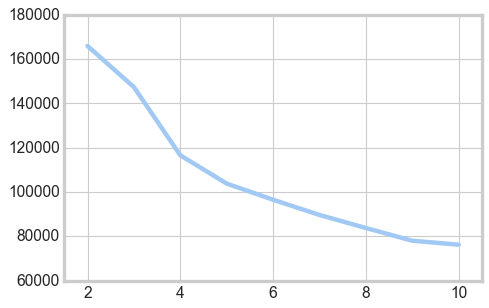

In [146]:
plt.plot(np.arange(2,2+prot.shape[0]),prot.index)
plt.xlim(1.5,10.5)